In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd

In [22]:
my_transfrom = transforms.Compose([transforms.Resize((64,64)),transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip(), transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(root = 'DATA', transform= my_transfrom)

In [23]:
dataset.classes

['Circles', 'Stars', 'Triangles']

In [24]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])

# 80% training

In [25]:
len(train_dataset)

456

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)

In [27]:
train_dataset[0][1]

2

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
train_loader

# My Net

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 8, 5, padding = 2)
        self.layer2 = nn.Conv2d(8, 16, 5, padding = 2)
        self.layer3 = nn.Conv2d(16, 32, 5, padding = 2)
        self.layer4 = nn.Conv2d(32, 32, 5, padding = 2)
        self.layer5 = nn.Conv2d(32, 32, 5, padding = 2)
        self.layer6 = nn.Linear(32*64*64, 3)
        self.relu = nn.ReLU()
    def forward(self, x):
        l = self.relu(self.layer1(x))
        l = self.relu(self.layer2(l))
        l = self.relu(self.layer3(l))
        l = self.relu(self.layer4(l))
        l = self.relu(self.layer5(l))
        l = l.view(-1,32*64*64)
        return F.softmax(self.layer6(l), dim=1)

In [31]:
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001) 
loss_fn = nn.MSELoss()

losses = []
accuracy = []

In [32]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [33]:
epochs = 5
for epoch in range (epochs):
    
    total_correct = 0
    total = len(train_dataset)
    
    for images, labels in train_loader:

        hot_predictions =  net(images) 
        predictions = hot_predictions.argmax(axis=1)
        nb_correct = sum(predictions == labels)
        
        total_correct += nb_correct
        
        hot_labels = F.one_hot(labels, 3).to(torch.float32) 

        loss = loss_fn(hot_labels, hot_predictions)  
        loss.backward()
        losses.append(loss.item())
        opt.step()
        opt.zero_grad()
    acc =  total_correct/total
    accuracy.append(acc.item())
    print(epoch, acc)

0 tensor(0.3268)
1 tensor(0.3289)
2 tensor(0.3706)
3 tensor(0.3728)
4 tensor(0.3355)
5 tensor(0.3268)
6 tensor(0.3377)
7 tensor(0.3662)
8 tensor(0.3662)
9 tensor(0.3662)
10 tensor(0.3662)
11 tensor(0.3706)
12 tensor(0.3772)
13 tensor(0.4890)
14 tensor(0.5680)
15 tensor(0.6140)
16 tensor(0.6930)
17 tensor(0.7193)
18 tensor(0.7368)
19 tensor(0.7127)
20 tensor(0.7675)
21 tensor(0.7522)
22 tensor(0.7719)
23 tensor(0.8026)
24 tensor(0.8224)
25 tensor(0.8246)
26 tensor(0.8311)
27 tensor(0.8289)
28 tensor(0.8289)
29 tensor(0.8246)
30 tensor(0.8465)
31 tensor(0.8553)
32 tensor(0.8268)
33 tensor(0.8487)
34 tensor(0.8640)
35 tensor(0.8684)
36 tensor(0.8640)
37 tensor(0.8618)
38 tensor(0.8487)
39 tensor(0.8684)
40 tensor(0.8882)
41 tensor(0.8750)
42 tensor(0.8816)
43 tensor(0.8706)
44 tensor(0.9013)
45 tensor(0.9101)
46 tensor(0.9079)
47 tensor(0.9013)
48 tensor(0.8816)
49 tensor(0.9232)
50 tensor(0.9101)
51 tensor(0.9057)
52 tensor(0.9145)
53 tensor(0.9189)
54 tensor(0.9167)
55 tensor(0.9298)
56

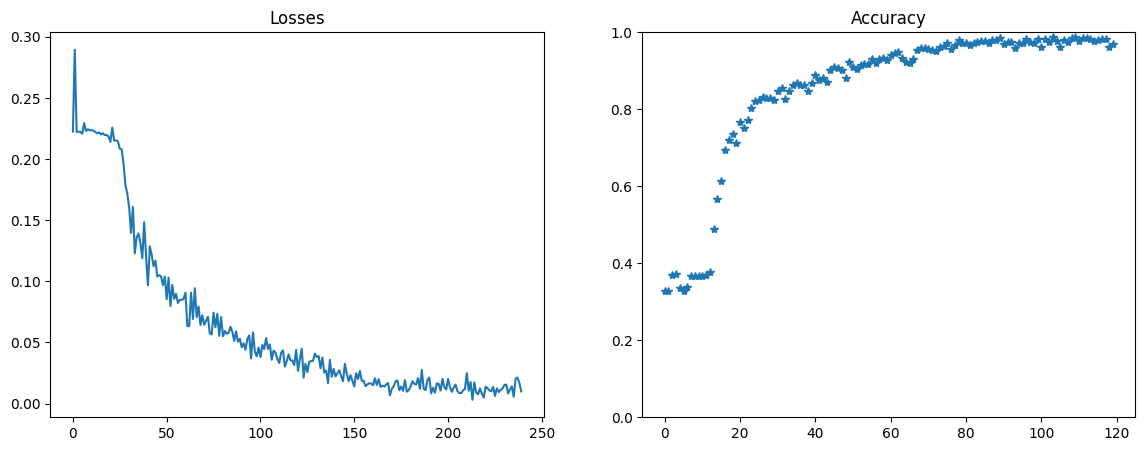

In [40]:
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(accuracy, '*')
plt.ylim(0,1) #bc we know the first 10%
plt.title("Accuracy")
plt.show()

# Let's test it

In [41]:
total_correct = 0
total = test_size
for images, labels in test_loader:
    hot_predictions = net(images)
    predictions = hot_predictions.argmax(axis=1)
    nb_correct = sum(predictions == labels)
    total_correct += nb_correct
    hot_labels = F.one_hot(labels, 3).to(torch.float32)
    loss = loss_fn(hot_labels, hot_predictions)
    loss.backward()
    opt.step()
    opt.zero_grad()
acc = total_correct/total
print(f"Accuracy: {acc}")

Accuracy: 0.9217391014099121


# Let's save the model

In [36]:
# torch.save(net, 'shapes_net100.pkl')

In [42]:
images.shape

torch.Size([115, 3, 64, 64])

# Onnx

In [43]:
dummy_input = torch.ones(1, 3, 64, 64)

In [44]:
torch.onnx.export(net, dummy_input, 'FioShapes.onnx', export_params = True, verbose = True)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# test